## Description
Simple resnet18 code to train a dodgy eye-tracker. It jumps around a lot, but for purely image input on a relatively small dataset for the task it does a surprisingly good job.



With around 6K samples of me in different lighting conditions, distances, postures, head rotations and offsets, I hit an MSE loss of around 0.0067, which is still an error range of a couple hundred pixels.
I noticed a dramatic jump in performance going from 4K samples to 6K, so I definitely think there's plenty more that can be learned with just more samples alone.


Loss dropped to around 0.005 with ~7K samples, but I didn't notice a significant improvement when actually running the model (possibly a dataset issue).


## Possible improvements:
To accurately predict, the model needs to infer info about:
    - Distance to face
    - Rotation of head
    - Rotation of eyes
    - Head offset
    - Camera offset and rotation
    - Screen dimensions
    
Hopefully by feeding in a few of these features it'll improve convergence time and allow it to track other features better.
Tools like dlib facial landmarks could probably be used to track head rotation and offset (in image space), and possibly distance with some maths around distance between features accounting for rotation (no idea what that equation looks like).


To be able to generalize to different setups and people, you'd want to pass in user specific info like display dimensions and camera position & rotation in a configuration step.



Possibly a configuration step could have the user look at five points (centre and corners of monitor), track some features from that like distance and eye + head rotation, and pass that in. I think that would only be effective with a larger dataset of different configurations.


In [2]:
!pip install fastbook -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [1]:
from fastai.basics import *
from fastai.imports import *
from fastai.vision.all import *


In [2]:
from fastbook import *

In [3]:
#| echo: True
#| output: True
import os
import sys

In [4]:
#| echo: True
#| output: True

# checks if the environment is local or remote
def check_if_local():
    # Checking for common remote environment indicators
    remote_indicators = ['COLAB_GPU', 'JUPYTERHUB_SERVICE_PREFIX']

    # If any of the indicators are present, it's likely not a local environment
    if any(indicator in os.environ for indicator in remote_indicators):
        return False
    else:
        # Assuming local environment if none of the remote indicators are found
        return True


In [7]:
#| echo: True
#| output: False

# checks if the environment is local or remote and sets the path accordingly
if check_if_local() == False:
    print('Running in a remote environment, mounting Google Drive...')
    from google.colab import drive
    drive.mount('/content/drive')
    #sys.path.append('/content/drive/MyDrive/Learning/data_science/')
    path = Path('/content/drive/MyDrive/Learning/data_science/datasets/gaze-points') # dataset path
    img_files = path.ls()
else :
    print('Running in a local environment...')
    sys.path.append('G:\My Drive\Learning\data_science')
    path = Path('G:\My Drive\Learning\data_science\datasets\gaze-points') # dataset path
    img_files = path.ls()


Running in a local environment...


In [47]:
def get_y(fname):
    # Extract target variables (coordinates) from filename
    coords = os.path.basename(fname).split('_')[1:]

    x, y = coords[0], coords[1].replace('.png', '') # remove the ".png" extension
    
    return int(x), int(y)

In [48]:
get_y(img_files[0])

['81', '606.png']

In [49]:
get_image_files(path)

(#327) [Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-173729_81_606.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-173726_2555_1383.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-173729_1818_1350.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-173727_2509_1137.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-174256_95_59.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-174255_47_899.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-174254_17_975.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-174254_62_996.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-174256_38_969.png'),Path('G:/My Drive/Learning/data_science/datasets/gaze-points/20240109-174257_1403_1400.png')...]

In [50]:
dbock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),  # Image and Regression target
    get_items=get_image_files,
    get_y=get_y,  # Get labels
    splitter=RandomSplitter(),
    item_tfms=Resize((240, 320)),  # Resize by half on both dims
    batch_tfms=[*aug_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_warp=0, max_lighting=0.35, p_lighting=.85)]
)


In [51]:
path

Path('G:/My Drive/Learning/data_science/datasets/gaze-points')

In [52]:
dls = dbock.dataloaders(path, bs=32) # Worth experimenting here, I did find lower batch sizes seemed to help, but worth trying a few nums

ValueError: too many dimensions 'str'

AttributeError: 'tuple' object has no attribute 'show'

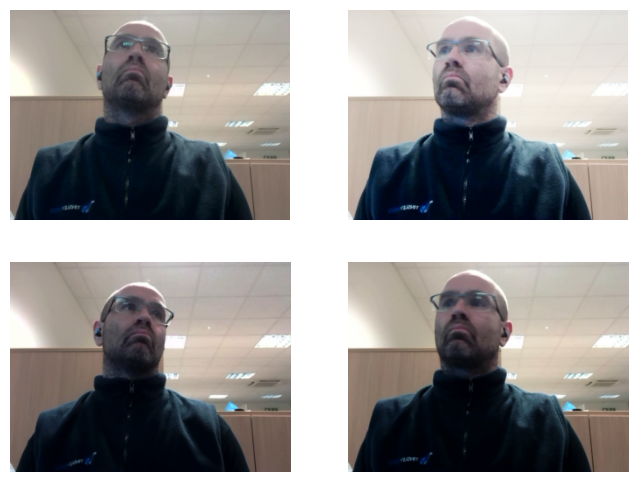

In [41]:
dls.show_batch(max_n=4, figsize=(8,6))

In [42]:
def pixel_loss (y_pred,yhat):
    """
    experimental loss func, doesn't seem to be effective.
    The idea was that MSE might be struggling with nums lower than <0.007 (which is the wall I seem to be hitting)

    """

    y_pred,yhat = TensorBase(y_pred), TensorBase(yhat)


    return ((yhat-y_pred)**2).mean() + (yhat-y_pred).abs().sqrt().mean()

pixel_loss(tensor([0.85, 12]).to('cuda'), tensor([0.8, 0.01]).to('cuda'))

TensorBase(73.7244, device='cuda:0')

In [43]:
def pixel_error (y_pred,yhat):
    y_pred,yhat = TensorBase(y_pred), TensorBase(yhat)

    return (yhat-y_pred)* TensorBase(3440).to('cuda') # dodgy metric setup for pixel distance, should really by the mean of width and height
pixel_loss(tensor([0.85, 12]).to('cuda'), tensor([0.87, 12]).to('cuda'))

TensorBase(0.0709, device='cuda:0')

In [44]:
learn = vision_learner(dls, resnet18, y_range=(0,1)) # for some reason y_range of (-1, 1) was super dodgy (the loss accounted for the different range), had 10x better results with 0-1


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\tblocal/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 8.27MB/s]


In [45]:
learn.loss_func

FlattenedLoss of MSELoss()

In [46]:
learn.lr_find()

AttributeError: 'tuple' object has no attribute 'dtype'

In [ ]:
learn.fine_tune(20, 1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,time
0,0.123989,0.100475,01:10
1,0.072540,0.048476,01:07
2,0.048436,0.032496,01:07


epoch,train_loss,valid_loss,time
0,0.023732,0.016475,01:09
1,0.016140,0.013278,01:08
2,0.014983,0.019689,01:08
3,0.014178,0.015712,01:05
4,0.012420,0.019335,01:05
5,0.011721,0.011476,01:06
6,0.011062,0.008148,01:05
7,0.008474,0.007447,01:05
8,0.008182,0.006854,01:04
9,0.007952,0.009017,01:05


In [ ]:
learn.export('gaze_pred.pkl')

In [ ]:
learn.fit_one_cycle(15, slice(2e-5, 1e-7))

epoch,train_loss,valid_loss,time
0,0.003776,0.004959,00:49
1,0.003683,0.005085,00:50
2,0.004213,0.004937,00:49
3,0.003781,0.005053,00:49
4,0.004125,0.004933,00:50
5,0.003739,0.004875,00:50
6,0.003621,0.005070,00:49
7,0.003888,0.004887,00:49
8,0.004157,0.004912,00:50
9,0.003526,0.004818,00:49


In [ ]:
learn.export('models/eye_tracker.pkl')

In [ ]:
#handy if you run out of video memory
import gc

# Collect garbage
gc.collect()

# Empty PyTorch cache
torch.cuda.empty_cache()
